# AIHC 5010 - Training Your First Models

## Chest/Abdomen Classification Tutorial

#### In this course you will learn how to run a deep learning experiment - from loading data, running a model, and deploying your model on a test dataset.

The original dataset is composed of Training (n=65), Validation (n=10), and Test (n=2). The test set images appear to no longer be publically available so we will do our own splitting of the data into Training (n=53), Validation (n=13), and Test (n=10) . The dataset has been annotated corresponding to the anatomy covered within the X-ray (i.e. chest or abdomen). Therefore, each image is related to a corresponding class/label.

The goal of the exercise is to develop a deep learning model that can learn to automatically classify the images as either being x-rays of the chest or the abdomen.

<img src="images/lesson1_datasetImage.png">

This updated notebook includes the original notebook provided in the course materials provided before the couse, as well as an updated section exploring a transfer learning based approach, as well as activation maps to visualize what the network focused on to make the classification decision

In [247]:
# Include the mdai module, output current mdai version
!pip install -q --upgrade mdai
import mdai
mdai.__version__

'0.7.8'

In [248]:
# Add mdai client
mdai_client = mdai.Client(domain='public.md.ai', access_token="b7f61f52767e27a00f83ab3686ede0e5")

Successfully authenticated to public.md.ai.


## Pull down data

After authenticating to MD.AI - you are now able to download available datasets. You can visit:

https://public.md.ai/hub/projects/public

To see the datasets that are available.

We are now going to pull down the data locally to your computer.

##### Note - on a Windows machine the Dicom files may cause an issue due to the length of file name. 

In this case you can change the path to store at a location closer to root

For example change path to:

path = 'C:/Users/Public/chest-abd-data'

Thus code will look like:

```python
p = mdai_client.project('PVq9raBJ', path='C:/Users/Public/chest-abd-data')
```

In [249]:
# Pull down dataset. Save into specified path (e.g., ./chest-abd-data)
p = mdai_client.project('PVq9raBJ', path='./chest-abd-data')

Using path './chest-abd-data' for data.
Preparing annotations export for project PVq9raBJ...                                                
Using cached annotations data for project PVq9raBJ.
Preparing images export for project PVq9raBJ...                                                     
Using cached images data for project PVq9raBJ.


In [250]:
# Show the corresponding label groups for the abdomen and chest
p.show_label_groups()

Label Group, Id: G_BdW4M5, Name: Default group
	Labels:
	Id: L_38Y7Jl, Name: Abdomen
	Id: L_z8xEkB, Name: Chest



### We will now map the label ids to the corresponding class ids in the form of a dictionary object

In [251]:
# The following maps label ids to class ids as a dict obj
labels_dict = {'L_38Y7Jl':0, # Abdomen 
               'L_z8xEkB':1, # Chest  
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_38Y7Jl': 0, 'L_z8xEkB': 1}


In [252]:
# show dataset ID and label mappings
p.show_datasets() 

Datasets:
Id: D_8ogmzN, Name: TRAIN
Id: D_OoJ98E, Name: VAL
Id: D_8oAvmQ, Name: TEST



In [253]:
# create training dataset 
train_dataset = p.get_dataset_by_name('TRAIN')
train_dataset.prepare() 
train_image_ids = train_dataset.get_image_ids()

print('Split train set')
train_dataset, validation_dataset = mdai.common_utils.train_test_split(train_dataset, validation_split = 0.25)
train_image_ids = train_dataset.get_image_ids()
val_image_ids = val_dataset.get_image_ids()

# create the test dataset 
test_dataset = p.get_dataset_by_name('VAL')
test_dataset.prepare()
test_image_ids = test_dataset.get_image_ids()

print('The number of images in the test dataset is: ' + str(len(test_dataset.image_ids)))


Split train set
Num of instances for training set: 48, validation set: 17
The number of images in the test dataset is: 10


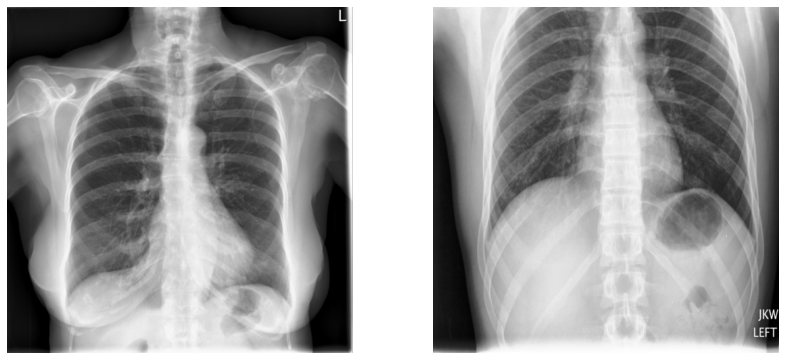

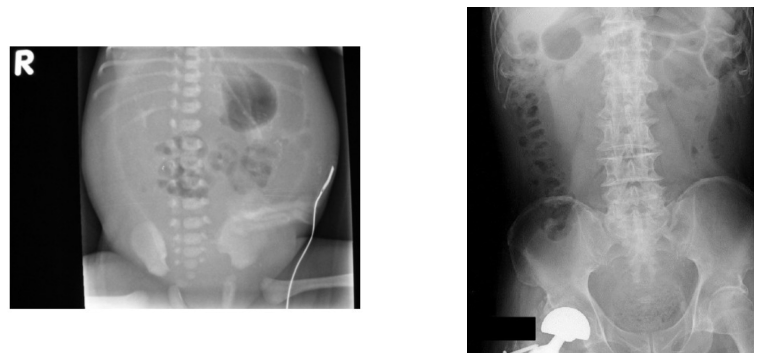

In [254]:
# visualize a few training images 
mdai.visualize.display_images(train_image_ids[:2], cols=2)
mdai.visualize.display_images(val_image_ids[:2], cols=2)

### Image files are a range of different sizes, the following shows how to read an example image from the training set and print out the size of the image

In [255]:
import numpy as np
# get image pixel data
pixel_array = mdai.visualize.load_dicom_image(train_image_ids[0], to_RGB=False, rescale=False)
print('The size of the image is:')
print(np.shape(pixel_array))

The size of the image is:
(512, 512)


### Import keras modules and begin defining model parameters.

In [256]:
# Import keras module
import tensorflow as tf
from tensorflow.keras import applications
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dropout, Flatten, Dense, GlobalAveragePooling2D, Conv2D
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend

In [257]:
# Define model parameters 
img_width = 192
img_height = 192
epochs = 10

params = {
    'dim': (img_width, img_height),
    'batch_size': 6,
    'n_classes': 2,
    'n_channels': 3,
    'shuffle': True,
}

# Begin Defining Model

Here we build up a very basic CNN architecture (similar in nature to the VGG class of architectures).

Here is where you can feel free to experiment with different architectures and tune the hyperparameters of the network. You should observe differences in training performance, as well as the amount of time required to fully train the network. 

Try changing the number of kernels in the network from 32 down to 16.

For example:

```python
conv1 = Conv2D(16, (3,3), activation = 'relu', padding='same')(inputs)
```

Or changing the size of the filter kernels from 3x3 to 5x5

```python
conv1 = Conv2D(32, (5,5), activation = 'relu', padding='same')(inputs)
```

Or the activation function for the output:

```python
conv1 = Conv2D(32, (3,3), activation = 'tanh', padding='same')(inputs)
```

How do these parameters affect performance and training time?

In [258]:
# Create a basic CNN architecture

inputs = Input((img_width, img_height, 3))

# Block1
conv1 = Conv2D(32, (3,3), activation = 'relu', padding='same')(inputs)
conv2 = Conv2D(32, (3,3), activation = 'relu', padding='same')(conv1)
max1 = MaxPooling2D((4,4), strides = (4,4))(conv2)

# Block2
conv3 = Conv2D(64, (3,3), activation = 'relu', padding='same')(max1)
conv4 = Conv2D(64, (3,3), activation = 'relu', padding='same')(conv3)
max2 = MaxPooling2D((4,4), strides = (4,4))(conv4)

fcn = Flatten()(max2)
fcn = Dense(256,activation='relu')(fcn)
fcn = Dropout(0.2)(fcn)
fcn = Dense(128,activation='relu')(fcn)
fcn = Dropout(0.1)(fcn)
output = Dense(2,activation='softmax')(fcn)

model = Model(inputs,output)

model.compile(optimizer=Adam(lr=1.E-5, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0), 
              loss='categorical_crossentropy', metrics=['accuracy'])

# End Defining Model

Now we will set up the data generators that will be used during training of the neural network

In [259]:
from mdai.visualize import load_dicom_image
import numpy as np
from PIL import Image


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(
        self,
        dataset,
        batch_size=32,
        dim=(32, 32),
        n_channels=1,
        n_classes=10,
        shuffle=True,
        to_RGB=True,
        rescale=False,
    ):
        """Generates data for Keras fit_generator() function.
        """

        # Initialization
        self.dim = dim
        self.batch_size = batch_size

        self.img_ids = dataset.image_ids
        self.imgs_anns_dict = dataset.imgs_anns_dict
        self.dataset = dataset

        self.n_channels = n_channels
        self.n_classes = n_classes
        self.shuffle = shuffle
        self.to_RGB = to_RGB
        self.rescale = rescale
        self.on_epoch_end()

    def __len__(self):
        "Denotes the number of batches per epoch"
        return int(np.floor(len(self.img_ids) / self.batch_size))

    def __getitem__(self, index):
        "Generate one batch of data"

        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]

        # Find list of IDs
        img_ids_temp = [self.img_ids[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(img_ids_temp)

        return X, y

    def on_epoch_end(self):
        "Updates indexes after each epoch"
        self.indexes = np.arange(len(self.img_ids))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __data_generation(self, img_ids_temp):
        "Generates data containing batch_size samples"

        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, ID in enumerate(img_ids_temp):
            image = load_dicom_image(ID, to_RGB=self.to_RGB, rescale=self.rescale)
            try:
                image = Image.fromarray(image)
            except Exception:
                print(
                    "Pil.Image can't read image. Possible 12 or 16 bit image. Try rescale=True to "
                    + "scale to 8 bit."
                )

            image = image.resize((self.dim[0], self.dim[1]))

            X[i,] = image

            ann = self.imgs_anns_dict[ID][0]
            y[i] = self.dataset.classes_dict[ann["labelId"]]["class_id"]
        return X, tf.keras.utils.to_categorical(y, num_classes=self.n_classes)

In [260]:
#from mdai.utils import keras_utils
train_generator = keras_utils.DataGenerator(train_dataset, **params)
val_generator = keras_utils.DataGenerator(val_dataset, **params)

In [261]:
import tensorflow as tf 
config = tf.compat.v1.ConfigProto() #update for tf2 compatibility
config.gpu_options.allow_growth = True

# Train Model

In [262]:
# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, verbose=2),
    ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', 
                    save_best_only=True, verbose=2)
]

history = model.fit_generator(
            generator=train_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1, #on a Windows machine you may want to use verbose=0           
            validation_data=val_generator,
            use_multiprocessing=False,
            workers=4)             

Epoch 1/10
8/8 [==============================] - 3s 347ms/step - loss: 6.2967 - accuracy: 0.7083 - val_loss: 1.4040 - val_accuracy: 0.6667

Epoch 00001: val_loss improved from inf to 1.40399, saving model to best_model.h5
Epoch 2/10
8/8 [==============================] - 3s 327ms/step - loss: 5.6844 - accuracy: 0.6250 - val_loss: 0.2834 - val_accuracy: 0.6667

Epoch 00002: val_loss improved from 1.40399 to 0.28341, saving model to best_model.h5
Epoch 3/10
8/8 [==============================] - 3s 347ms/step - loss: 2.7300 - accuracy: 0.7083 - val_loss: 1.2899 - val_accuracy: 0.6667

Epoch 00003: val_loss did not improve from 0.28341
Epoch 4/10
8/8 [==============================] - 3s 325ms/step - loss: 3.0035 - accuracy: 0.6875 - val_loss: 0.0262 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.28341 to 0.02617, saving model to best_model.h5
Epoch 5/10
8/8 [==============================] - 3s 337ms/step - loss: 2.1639 - accuracy: 0.7500 - val_loss: 0.0351 - val_accuracy

### ----------------------- Finish Training -----------------------

#### Now our network is trained. We can generate learning curves that visualize how the model performed on the training and validation sets

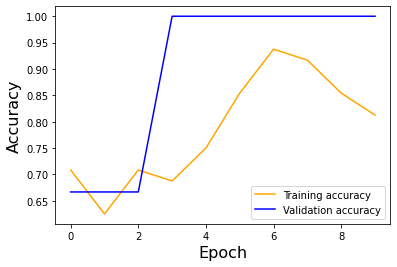

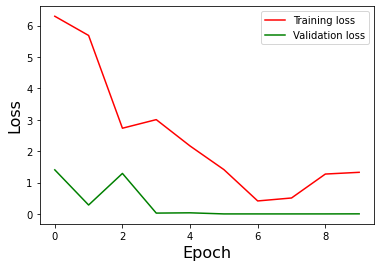

In [263]:
import matplotlib.pyplot as plt

#print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize = 16)
plt.show()

plt.figure()
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

Studying learning curves gives insight into how the network is performing and assess properties such as whether overfitting is an issue.

# Create the Test dataset

In this example we have an example image from each class (i.e. one abdominal and one chest X-ray). Let's find out how our model performs on this hold out test set.

In [264]:
model.load_weights('best_model.h5')
#test_dataset = p.get_dataset_by_name('TEST') #mdai lost the test set images it seems.
#test_dataset.prepare()
#print(len(test_dataset.image_ids))

### Make a prediction on the test images as to whether they are a chest X-ray or if they are an abdominal X-ray

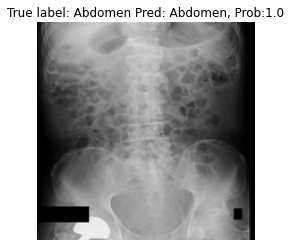

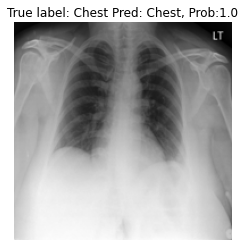

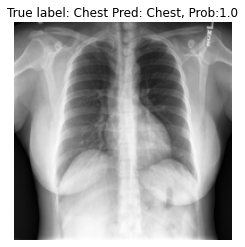

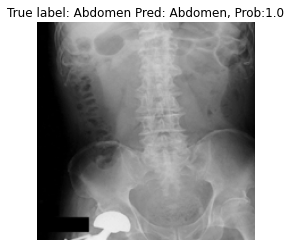

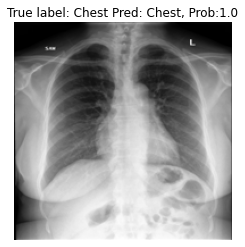

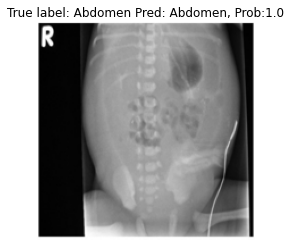

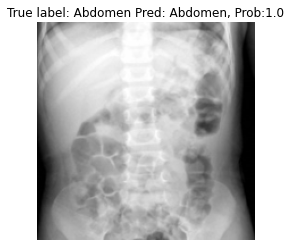

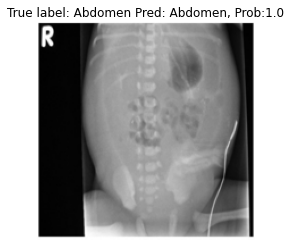

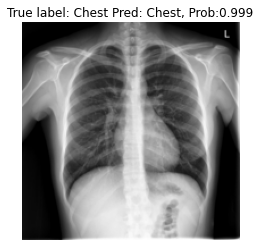

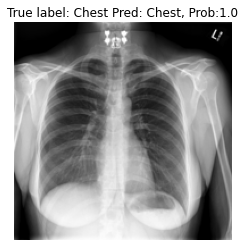

In [265]:
import numpy as np
#from skimage.transform import resize
from PIL import Image 

for image_id in test_dataset.image_ids: 
    
    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))
    
    x = np.expand_dims(image, axis=0)    
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    
    anns = test_dataset.get_annotations_by_image_id(image_id)
    for ann in anns:
      labelId = ann['labelId']
      if labelId == 'L_38Y7Jl':
        labelText = 'Abdomen'
      if labelId == 'L_z8xEkB':
        labelText = 'Chest'

    #print(labelId)
    title = 'True label: ' + labelText + ' Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', Prob:' + str(round(y_prob[0][y_classes[0]], 3))
    
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()

## Congratulations, you have just run a deep learning experiment!

The experiment used a CNN architecture to learn to distinguish abdominal X-rays from chest X-rays.

Continue experimenting with the code contained in this notebook. We will start the course with a discussion of important concepts related to machine/deep learning. We will then work through this notebook, as well as others that will be downloaded during the course.

Now is the time to ask yourself:

- How did your model perform?

- Did it correctly identify whether an X-ray was from the chest or abdomen?

- What other network parameters could you experiment with to try to further improve performance?

## ------------ Transfer Learning Slides -----------------

Now let's work through a transfer learning type example with the same dataset

In [266]:
base_model = applications.mobilenet.MobileNet(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))

model_top  = Sequential()
model_top.add(GlobalAveragePooling2D(input_shape=base_model.output_shape[1:], data_format=None))
model_top.add(Dense(128, activation='relu'))
model_top.add(Dropout(0.1))
model_top.add(Dense(2, activation='softmax')) 

model = Model(inputs=base_model.input, outputs=model_top(base_model.output))

model.compile(optimizer=Adam(lr=0.00001, beta_1=0.9, beta_2=0.999, epsilon=1e-08,decay=0.0), 
              loss='categorical_crossentropy', metrics=['accuracy'])

In [267]:
# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, verbose=2),
    ModelCheckpoint(filepath='best_model_tl.h5', monitor='val_loss', 
                    save_best_only=True, verbose=2)
]

history = model.fit_generator(
            generator=train_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1, #on a Windows machine you may want to use verbose=0           
            validation_data=val_generator,
            use_multiprocessing=False,
            workers=4)  

Epoch 1/10
8/8 [==============================] - 6s 482ms/step - loss: 0.7128 - accuracy: 0.6667 - val_loss: 0.5187 - val_accuracy: 0.8333

Epoch 00001: val_loss improved from inf to 0.51874, saving model to best_model_tl.h5
Epoch 2/10
8/8 [==============================] - 4s 434ms/step - loss: 0.4754 - accuracy: 0.8333 - val_loss: 0.6134 - val_accuracy: 0.6667

Epoch 00002: val_loss did not improve from 0.51874
Epoch 3/10
8/8 [==============================] - 3s 423ms/step - loss: 0.3336 - accuracy: 0.8958 - val_loss: 0.6200 - val_accuracy: 0.5000

Epoch 00003: val_loss did not improve from 0.51874
Epoch 4/10
8/8 [==============================] - 3s 428ms/step - loss: 0.2386 - accuracy: 0.9583 - val_loss: 0.4802 - val_accuracy: 1.0000

Epoch 00004: val_loss improved from 0.51874 to 0.48016, saving model to best_model_tl.h5
Epoch 5/10
8/8 [==============================] - 3s 417ms/step - loss: 0.1825 - accuracy: 0.9792 - val_loss: 0.3972 - val_accuracy: 1.0000

Epoch 00005: val_lo

### Generate learning curves

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


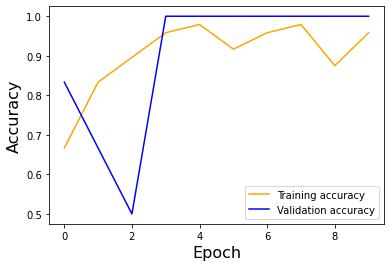

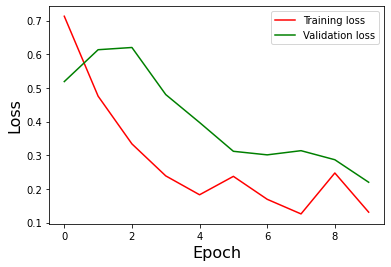

In [268]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize = 16)
plt.show()

plt.figure()
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

### Test model on the hold out set

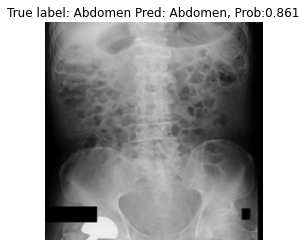

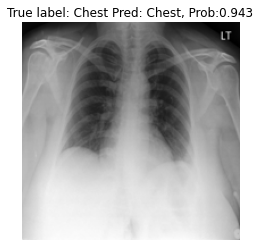

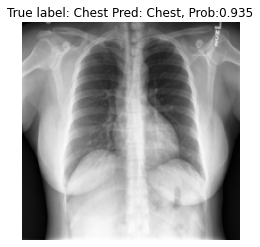

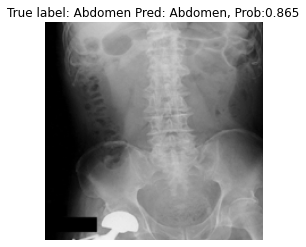

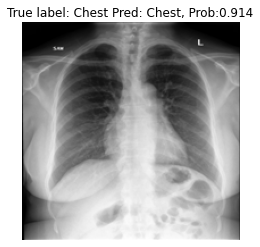

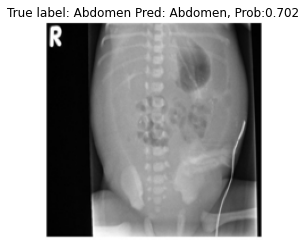

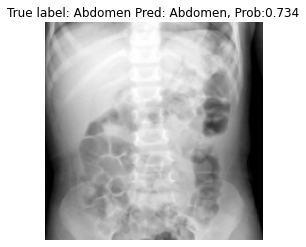

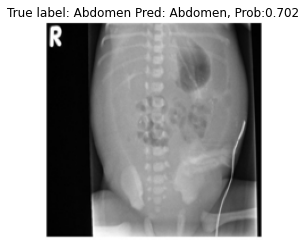

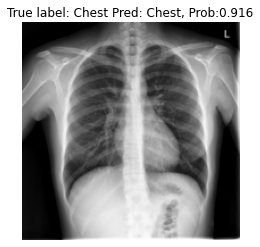

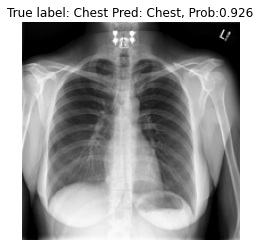

In [269]:
import numpy as np
#from skimage.transform import resize
from PIL import Image 

for image_id in test_dataset.image_ids: 
    
    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))
    
    x = np.expand_dims(image, axis=0)    
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    
    anns = test_dataset.get_annotations_by_image_id(image_id)
    for ann in anns:
      labelId = ann['labelId']
      if labelId == 'L_38Y7Jl':
        labelText = 'Abdomen'
      if labelId == 'L_z8xEkB':
        labelText = 'Chest'

    #print(labelId)
    title = 'True label: ' + labelText + ' Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', Prob:' + str(round(y_prob[0][y_classes[0]], 3))
    
    plt.figure()
    plt.title(title)
    plt.imshow(image)
    plt.axis('off')
    
plt.show()

## ------------ Activation Maps Slides ---------------

Another way the networks can be further explored is by characterizing the regions in an image that the network focuses on to make a decision. For this we will work on generating activation maps.

For most activation map approaches, networks have to be designed with some specific components that allow us to probe specific layers and generate which regions in an image are causing the most activation.

In [275]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Convolution2D, ZeroPadding2D, MaxPooling2D
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras import backend as K
import h5py
from tensorflow.keras.optimizers import SGD

def global_average_pooling(x):
    return K.mean(x, axis = (2,3))

def global_average_pooling_shape(input_shape):
    return input_shape[0:2]

def VGG_like_convolutions():
    model = Sequential()
    
    model.add(ZeroPadding2D((1,1),input_shape=(192,192,3)))
    model.add(Convolution2D(16, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(16, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(32, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(64, (3, 3), activation='relu', name='conv3_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Convolution2D(128, (3, 3), activation='relu', name='conv4_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    return model

def get_model_vgg_like():
    model = VGG_like_convolutions()
    
    model.add(Lambda(global_average_pooling, 
              output_shape=global_average_pooling_shape))
    #model.add(Dense(128, activation = 'relu'))
    #model.add(Dense(32, activation = 'relu'))
    model.add(Dense(2, activation = 'softmax', kernel_initializer='uniform'))
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.0, nesterov=True)
    model.compile(loss = 'categorical_crossentropy', 
                  optimizer=sgd,
                  metrics=['accuracy'])
    return model

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

model = get_model_vgg_like()

# Set callback functions to early stop training and save the best model so far
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=2),
    ModelCheckpoint(filepath='best_model_am2.h5', monitor='val_loss', 
                    save_best_only=True, verbose=2)
]

history = model.fit_generator(
            generator=train_generator,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1, #on a Windows machine you may want to use verbose=0           
            validation_data=val_generator,
            use_multiprocessing=False, #lots of warnings if 'True' on colab
            workers=4) 

Epoch 1/10
8/8 [==============================] - 4s 389ms/step - loss: 0.7096 - accuracy: 0.4792 - val_loss: 0.6976 - val_accuracy: 0.3333

Epoch 00001: val_loss improved from inf to 0.69760, saving model to best_model_am2.h5
Epoch 2/10
8/8 [==============================] - 3s 345ms/step - loss: 0.6878 - accuracy: 0.5208 - val_loss: 0.7117 - val_accuracy: 0.3333

Epoch 00002: val_loss did not improve from 0.69760
Epoch 3/10
8/8 [==============================] - 3s 348ms/step - loss: 0.6830 - accuracy: 0.5208 - val_loss: 0.7151 - val_accuracy: 0.3333

Epoch 00003: val_loss did not improve from 0.69760
Epoch 4/10
8/8 [==============================] - 3s 350ms/step - loss: 0.6930 - accuracy: 0.5208 - val_loss: 0.7207 - val_accuracy: 0.3333

Epoch 00004: val_loss did not improve from 0.69760
Epoch 5/10
8/8 [==============================] - 3s 355ms/step - loss: 0.6725 - accuracy: 0.5208 - val_loss: 0.7189 - val_accuracy: 0.3333

Epoch 00005: val_loss did not improve from 0.69760
Epoch

In [276]:
import cv2

def get_output_layer(model, layer_name):
    # get the symbolic outputs of each "key" layer (we gave them unique names).
    layer_dict = dict([(layer.name, layer) for layer in model.layers])
    layer = layer_dict[layer_name]
    return layer

def visualize_class_activation_map(model, img):
    model = model
    original_img = img
    width = 192
    height = 192

    #Get the 512 input weights to the softmax.
    class_weights = model.layers[-1].get_weights()[0]
    final_conv_layer = get_output_layer(model, "conv4_2")
    get_output = K.function([model.layers[0].input], \
        [final_conv_layer.output, 
    model.layers[-1].output])
    [conv_outputs, predictions] = get_output([np.float32(img)])
    
    conv_outputs = conv_outputs[0, :, :, :]
    
    #Create the class activation map.
    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[0:2])
    for i, w in enumerate(class_weights[:, 1]):
            cam += w * conv_outputs[:, :, i]
    #print("predictions", predictions)

    cam = cv2.resize(cam, (height, width))

    return cam



### Visualize the activation maps overlaid on the test images

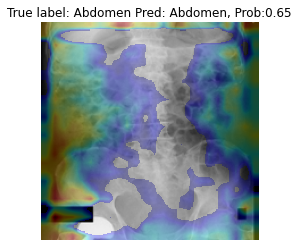

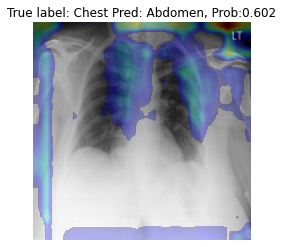

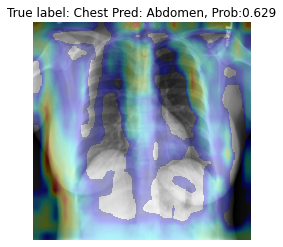

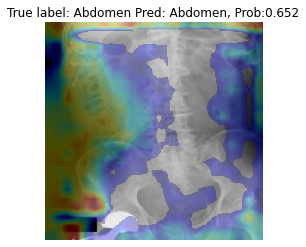

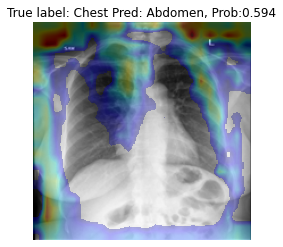

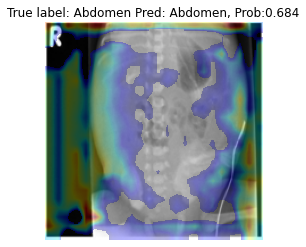

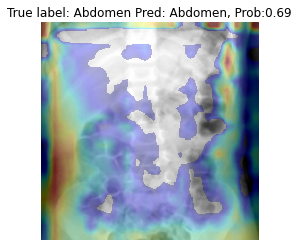

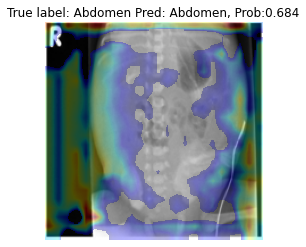

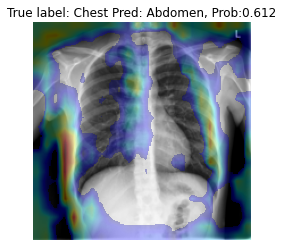

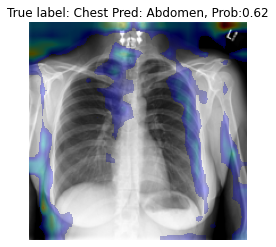

In [277]:
import numpy as np
from PIL import Image 

for image_id in test_dataset.image_ids: 
    
    image = mdai.visualize.load_dicom_image(image_id, to_RGB=True)
    image = Image.fromarray(image)
    image = image.resize((img_width, img_height))
    
    x = np.expand_dims(image, axis=0)    
    y_prob = model.predict(x) 
    y_classes = y_prob.argmax(axis=-1)
    
    anns = test_dataset.get_annotations_by_image_id(image_id)
    for ann in anns:
      labelId = ann['labelId']
      if labelId == 'L_38Y7Jl':
        labelText = 'Abdomen'
      if labelId == 'L_z8xEkB':
        labelText = 'Chest'

    #print(labelId)
    title = 'True label: ' + labelText + ' Pred: ' + test_dataset.class_id_to_class_text(y_classes[0]) + ', Prob:' + str(round(y_prob[0][y_classes[0]], 3))
    
    plt.figure()
    plt.title(title)
    plt.imshow(image, cmap='jet')
    plt.axis('off')
    
    # Add the activation map overlay
    cam = visualize_class_activation_map(model, x)
    cam = cam - np.min(cam)
    cam[cam<np.max(cam)/2]=0
    masked = np.ma.masked_where(cam == 0, cam)
    plt.imshow(masked,cmap='jet',alpha=0.3)
    plt.axis('off')
    
plt.show()

### Generate learning curves for this final network

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


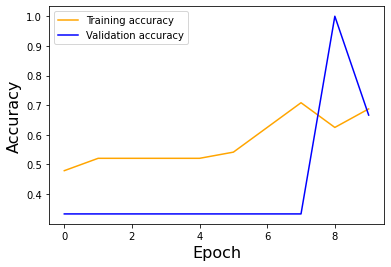

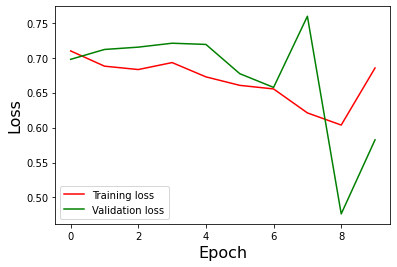

In [278]:
print(history.history.keys())

plt.figure()
plt.plot(history.history['accuracy'], 'orange', label='Training accuracy')
plt.plot(history.history['val_accuracy'], 'blue', label='Validation accuracy')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize = 16)
plt.show()

plt.figure()
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.show()

# Great work!!!

Feel free to experiment with any of the cells in the spreadsheet. Particularly testing out different network architectures and trying to optimize hyperparameters as well.

One way to do this is to first copy this notebook and try making changes there. This way you keep a clean original copy.

Feel free to continue working further on in this notebook to:

- Develop new models
- Work on ways to evaluate models
- etc. etc. etc.